In [1]:
pwd

'/home/mtech/2020/satyaki_ghosh/codes/Rajesh/MISLGAN/GAN_architecture_testing'

In [2]:
import numpy as np
from multiprocessing import dummy
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from sklearn.feature_extraction import image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.backend.tensorflow_backend import set_session

from sklearn.metrics import confusion_matrix, classification_report
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

#DYNAMICALLY GROW THE GPU MEMORY
print(tf.test.is_gpu_available(cuda_only=True))
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True      
sess =  tf.compat.v1.Session(config=config)
set_session(sess) 


batch_size = 30
steps_per_epoch = 70
epochs = 1 # 30
IMG_SIZE = 256
DATADIR = "/home/mtech/2020/satyaki_ghosh/codes/Rajesh/MISLGAN/GAN_architecture_testing"


Using TensorFlow backend.


True


In [3]:
# LOAD SEED DATA
seed = []
with open('seed_patches.npy','rb') as f:
    xx = np.load(f, allow_pickle=True)
seed = list(xx)
random.shuffle(seed)
seed = np.array(seed)
seed = seed.reshape((-1,IMG_SIZE, IMG_SIZE, 1))
seed = seed/255.0
print(f"Seed data loaded. Shape : {seed.shape}")

Seed data loaded. Shape : (3980, 256, 256, 1)


In [4]:
# LOAD TRAINING DATA
x_train = []
with open('training_patches.npy','rb') as f:
    xx = np.load(f, allow_pickle=True)
x_train = list(xx)

x_train = np.array(x_train)
x_train = x_train/255.0
x_train = x_train.reshape((-1, IMG_SIZE, IMG_SIZE, 1))
if x_train.shape[0] > 0:
    print(f"Training data loaded. Shape: {x_train.shape}")
else:
    print("Training data too big to load.")


if not os.path.isdir("save_path"):
    os.mkdir("save_path")

Training data loaded. Shape: (2001, 256, 256, 1)


In [5]:
# LOAD GAN TESTING DATA
testing_data_GAN = []
with open('testing_patches.npy','rb') as f:
    xx = np.load(f, allow_pickle=True)
testing_data_GAN = list(xx)

# MAKE TEST SET
X_test_GAN_image = []
X_test_GAN_bayer = []
Y_test_GAN = []

for features_image,features_bayer,label in testing_data_GAN :
  X_test_GAN_image.append(features_image)
  X_test_GAN_bayer.append(features_bayer)
  Y_test_GAN.append(label)


X_test_GAN_bayer = np.array(X_test_GAN_bayer).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_test_GAN_bayer = X_test_GAN_bayer/255.0
X_test_GAN_image = np.array(X_test_GAN_image).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_test_GAN_image = X_test_GAN_image/255.0
Y_test_GAN = np.array(Y_test_GAN)
print("Testing data loaded.")
print(f"X_test_GAN_bayer : {X_test_GAN_bayer.shape}")
print(f"X_test_GAN_image : {X_test_GAN_image.shape}")
print(f"Y_test_GAN : {Y_test_GAN.shape}")

Testing data loaded.
X_test_GAN_bayer : (1000, 256, 256, 1)
X_test_GAN_image : (1000, 256, 256, 1)
Y_test_GAN : (1000,)


In [9]:
# EVALUTATE GAN
def GAN_performance(epoch, generator,seed_test_bayer,seed_test_image):
	# prepare fake examples
    y_pred_GAN = generator.predict(seed_test_bayer)
    #seed_test_image = X_test_GAN_image[50,100,150,200,250,350,400,450,500,550,650,700,750,800,850,950,1000,1050,1100,1150,1250,1300,1350,1400,1450]
    for j in range(5 * 5):
        plt.subplot(5, 5, j+1)
        plt.axis('off')
        plt.imshow(np.squeeze(seed_test_image[j]))
    plt.savefig('E:\IIT GUWAHATI\MTP\MTP_CODES\Rajesh\MISLGAN\seed_plots\seed_plot_%03d.png' % (epoch+1))
    plt.close()
   
	# plot images
    for i in range(5 * 5):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.imshow(y_pred_GAN[i])
	# save plot to file
    plt.savefig('E:\IIT GUWAHATI\MTP\camera-model-classfier\save_path\generated_plot_%03d.png' % (epoch+1))
    plt.close()
	# save the generator model
    generator.save('E:\IIT GUWAHATI\MTP\camera-model-classfier\save_path\generator_%03d.h5' % (epoch+1))


In [10]:
# CREATE GENERATOR
optimizer = Adam(0.0001, 0.5)
def create_generator(shape = (IMG_SIZE,IMG_SIZE,3)):
    input = Input(shape = (IMG_SIZE,IMG_SIZE,3))    
    
    layer_1 = Conv2D(64, (3, 3), strides = 1, padding = 'same')(input)
    layer_2 = Activation('relu')(layer_1)
    layer_3 = Conv2D(64, (3, 3), strides = 1, padding = 'same')(layer_2)
    layer_4 = Activation('relu')(layer_3)
    layer_5 = Conv2D(64,(1, 1), strides = 1, padding = 'same')(layer_4)
    layer_6 = Activation('relu')(layer_5)
        
    
    layer_7 = Conv2D(128, (3, 3), strides = 1, padding = 'same')(layer_6)
    layer_8 = Activation('relu')(layer_7)
    layer_9 = Conv2D(128, (3, 3), strides = 1, padding = 'same')(layer_8)
    layer_10 = Activation('relu')(layer_9)
    layer_11 = Conv2D(128, (1, 1), strides = 1, padding = 'same')(layer_10)
    layer_12 = Activation('relu')(layer_11)
    
    layer_13 = Conv2D(3, (3, 3), strides = 1, padding = 'same')(layer_12)
    layer_14 = Activation('relu')(layer_13)
    
    model = Model(inputs = input, outputs = layer_14)
    model.compile(loss = "binary_crossentropy", optimizer=optimizer, run_eagerly = True)
    
    return model

In [11]:
# CREATE DISCRIMINATOR
def normalise(w):
    j=int(w.shape[0]/2)
    for i in range(w.shape[-1]):
        w[j,j,:,i]=0
        for k in range(w.shape[-2]):
          wsum = w[:,:,k,i].sum()
          w[:,:,k,i]/=wsum
        w[j,j,:,i]=-1
    return w

num_filter=3
w = np.random.rand(5,5,3,num_filter)             #changing the number of filters change accordingly the last number 
wgt = normalise(w)
bias = np.zeros(num_filter)

opt = tf.keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9, decay = 0.0005)
# define the standalone discriminator model
def create_discriminator():
    model = Sequential()    

    model.add(Conv2D(96,(7,7),strides = (2,2), padding = 'same', input_shape=(IMG_SIZE,IMG_SIZE,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (3,3), strides = 2 ))

    model.add(Conv2D(64,(5,5),strides = (1,1), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (3,3), strides = 2))


    model.add(Conv2D(64,(5,5),strides = (1,1), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (3,3), strides = 2))


    model.add(Conv2D(128,(1,1),strides = (1,1), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

    model.add(Flatten())

    model.add(Dense(200))
    model.add(Activation('relu'))

    model.add(Dense(200))
    model.add(Activation('relu'))

    model.add(Dense(1, activation='sigmoid'))
    
	# compile model
    model.compile(loss = "binary_crossentropy", optimizer = optimizer , metrics = ['accuracy'])

    return model

In [12]:
# TRAIN THE GAN
discriminator = create_discriminator()
generator = create_generator()
discriminator.trainable = False
gan_input = Input(shape=(IMG_SIZE,IMG_SIZE,3))
fake_image = generator(gan_input)
gan_output = discriminator(fake_image)

gan = Model(inputs = [gan_input],outputs = [gan_output])
gan.compile(loss='binary_crossentropy', optimizer=optimizer)
print("Generator and Discriminator initialized. Starting training...")
   
d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
set = np.random.randint(0, X_test_GAN_image.shape[0], size=25)


import gc
gc.collect()

for epoch in range(epochs):
    for batch in range(steps_per_epoch) :    
        seed_epoch = seed[np.random.randint(0, seed.shape[0],size = batch_size)]#images of different classes
        seed_epoch = np.asarray(seed_epoch).astype('float32')
        fake_x = generator.predict(seed_epoch, verbose=10) #output of generator
        print("Starting GAN training")
        real_x = x_train[np.random.randint(0, x_train.shape[0],size = batch_size)] #images of target class
        
        d_train_y = np.zeros(2*batch_size)
        d_train_y[:batch_size] = 0.9
        d_train_x = np.concatenate((real_x,fake_x))
        
        print("Starting training of discriminator")
        d_loss,d_acc = discriminator.train_on_batch(d_train_x, d_train_y) #discriminator training 
        print("Discriminator trained")
        '''
        total_w = discriminator.layers[0].get_weights()
        w=np.array(total_w[0])
        bias = np.zeros(3)
        w = normalise(w)
        discriminator.layers[0].set_weights([w,bias])
        
        '''
        
        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch([seed_epoch],[y_gen]) #generator training with different classes and keeping output to real
        
    
        d1_hist.append(d_loss)
        d2_hist.append(d_acc)
        g_hist.append(g_loss)
        
        
        print(f'Epoch: {epoch} \t d_loss: {d_loss}  d_acc: {d_acc} g_loss: {g_loss}')
    seed_test_image = X_test_GAN_image[set]
    seed_test_bayer = X_test_GAN_image[set]
    #seed_test = X_test_GAN_bayer[50,100,150,200,250,350,400,450,500,550,650,700,750,800,850,950,1000,1050,1100,1150,1250,1300,1350,1400,1450]
    GAN_performance(epoch, generator,seed_test_bayer,seed_test_image)
print("GAN training complete.")

# plot generator and discriminator loss
plt.subplot(2, 1, 1)
plt.plot(d1_hist, label='d-loss')
plt.plot(g_hist, label='g_loss')
plt.legend()
plt.savefig('')
plt.close()


# plot discriminator accuracy
plt.subplot(2, 1, 2)
plt.plot(d2_hist, label='d-acc')
plt.legend()
plt.savefig()
plt.close()


Generator and Discriminator initialized. Starting training...


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

In [ ]:
## TODOS:
# keep train and test data separate
# write the attack code
# how to tackle \t  file path
# use rajesh's hyperparameters
# ensure to use whole data in every epoch instead of resampling due to randint
# is real and fake dataset distrib correct?

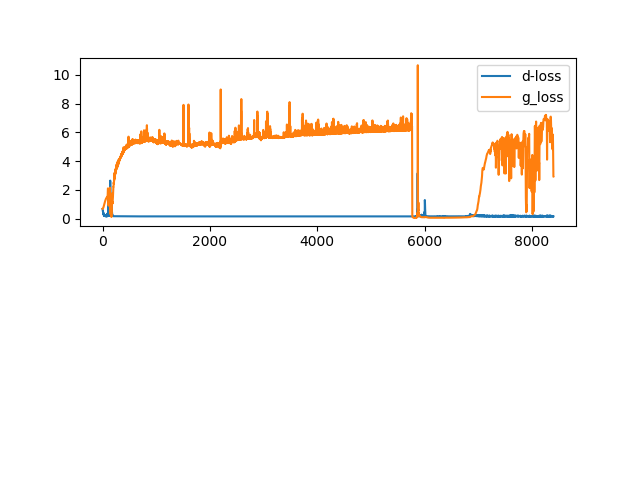

In [2]:
from IPython.display import Image
Image(filename='Loss.png') 

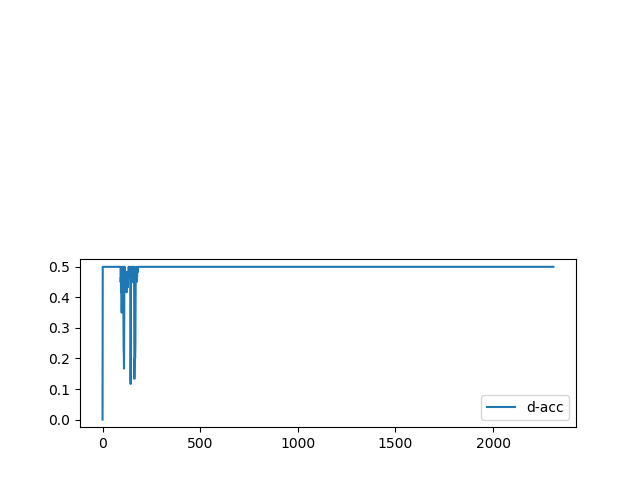

In [10]:
Image(filename='Accuracy.png') 

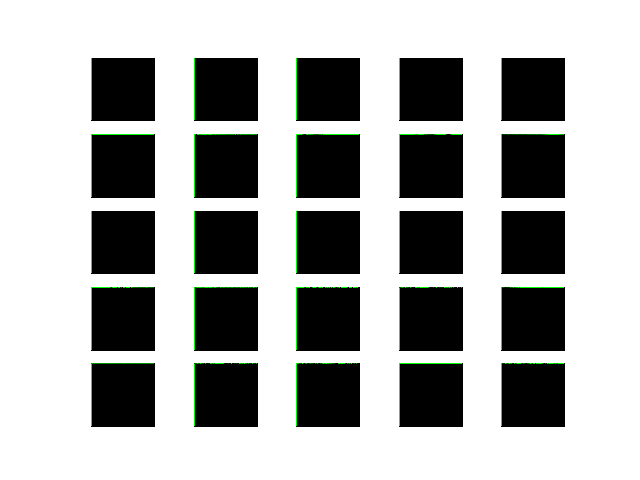

In [15]:
Image(filename='./save_path/generated_plot_095.png')

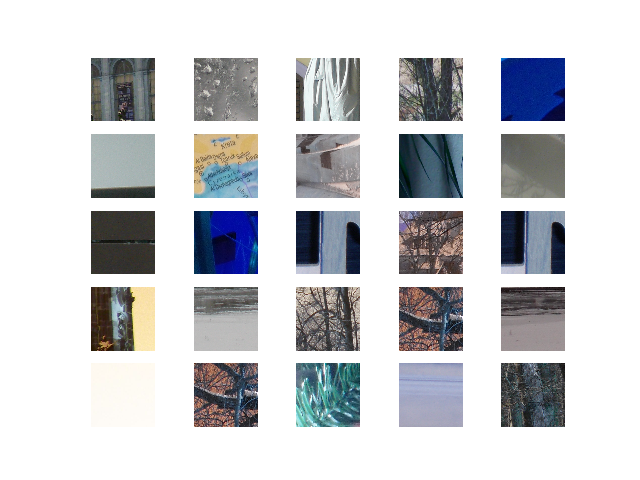

In [16]:
Image(filename='./seed_plots/seed_plot_095.png')